In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


## Yêu cầu bào toán
- Sử dụng python và opencv
- Tạo ảnh trắng size 400*200
- vẽ hình vuông size 20*20 ở chính giữa
- Chứng minh bản thân đúng

### 1.Khởi tạo tham số

In [40]:
# Khoi tao shape cua image va rec (bang dictionary)
'''
    Arguments:
        width: chieu rong cua anh (pixels)
        height: chieu cao cua anh (pixels)
        channels: so kenh mau cua anh (1 kenh cho anh xam, 3 kenh cho anh mau RGB)
        color: mau nen cua anh (RGB)
'''
image_attributes = {
                'width': 200,
                'height': 400,
                'channels': 3,
                'color': [255, 255, 255]
               } # white color in BGR

# Khoi tao shape cua rectangle (bang dictionary)
'''
    Arguments:
        width: chieu rong cua hinh chu nhat (pixels)
        height: chieu cao cua hinh chu nhat (pixels)
        channels: so kenh mau cua hinh chu nhat (1 kenh cho anh xam, 3 kenh cho anh mau RGB)
        color: mau cua hinh chu nhat (RGB)
'''
rec_attributes = {
                    'width': 20,
                    'height': 20,
                    'channels': 3,
                    'color': [0, 255, 0] # green theo yeu cau cua bai toan
                 }

### 2. Xây dựng Module tạo ảnh

In [41]:
class Image_Render:
    def __init__(self, image_attribute: dict) :
        self.width = image_attribute['width']
        self.height = image_attribute['height']
        self.channels = image_attribute['channels']
        self.color = image_attribute['color']

    def image_render_by_loop(self):
        # Tạo ảnh trắng
        image = np.zeros((self.height, self.width, self.channels), dtype=np.uint8)
        for i in range(self.height):
            for j in range(self.width):
                image[i, j] = self.color
        return image

    def image_render_by_numpy(self):
        return np.full((self.height, self.width, self.channels), self.color, dtype=np.uint8)



In [42]:
image = Image_Render(image_attributes).image_render_by_numpy()
rec = Image_Render(rec_attributes).image_render_by_numpy()

In [43]:
image.shape, rec.shape

((400, 200, 3), (20, 20, 3))

### 3. Xác định tâm của ảnh

##### 3.1 Giao của 2 đường chéo

In [60]:


def bresenham_line(A: tuple, B: tuple):
    """
    Vẽ một đường thẳng từ (x1, y1) đến (x2, y2)
    sử dụng thuật toán Bresenham.
    Trả về một danh sách các tọa độ điểm ảnh.
    """
    x1, y1 = A
    x2, y2 = B
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    # points = []
    input = []
    output = []
    x, y = x1, y1

    while True:
        input.append(x)
        output.append(y)

        if x == x2 and y == y2:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x += sx
        if e2 < dx:
            err += dx
            y += sy

    return np.array(input), np.array(output)


In [66]:
X, y = bresenham_line((0, 0), (image_attributes['width']-1, image_attributes['height']-1))
print(len(X))
print(len(y))

400
400


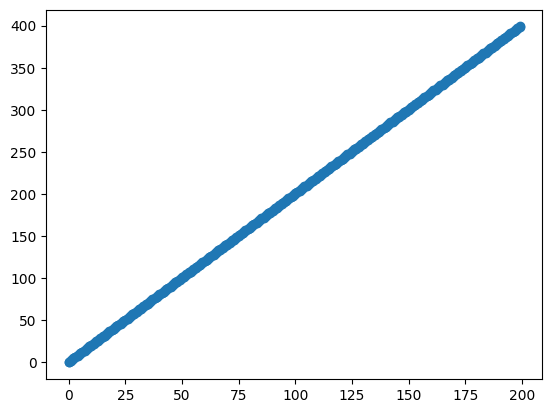

In [67]:
plt.scatter(X, y)
plt.show()

In [73]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
model = LinearRegression().fit(X, y)
model.coef_, model.intercept_  # coef_ = [[2.]], intercept_ = [-0.]

(array([[2.]]), array([0.5]))

In [75]:
# 2. Định nghĩa hàm log-likelihood
def log_likelihood(params, X, y):
    """
    Hàm log-likelihood cho mô hình hồi quy tuyến tính.
    params[0] là beta_0 (hệ số chặn)
    params[1] là beta_1 (hệ số góc)
    params[2] là sigma (độ lệch chuẩn của sai số)
    """
    beta_0, beta_1, sigma = params

    # Tính giá trị dự đoán từ mô hình
    y_pred = beta_0 + beta_1 * X # flatten() để chuyển X từ (n, 1) sang (n,)
    # Tính phần còn lại (sai số)
    residuals = y - y_pred

    # Tính log-likelihood
    # Hàm PDF của phân phối chuẩn: L(theta) = tích của PDF(yi | xi, theta)
    # Log-likelihood: LL(theta) = tổng của ln(PDF(yi | xi, theta))
    # ln(PDF) = -0.5 * ln(2*pi) - ln(sigma) - 0.5 * ((y - y_pred) / sigma)^2
    n = len(y)
    log_L = -n/2 * np.log(2 * np.pi) - n * np.log(sigma) - (1/(2 * sigma**2)) * np.sum(residuals**2)

    # SciPy's `minimize` tìm cực tiểu, nên ta phải tối thiểu hóa log-likelihood âm
    return -log_L

# 3. Ước lượng các tham số bằng cách tối thiểu hóa hàm log-likelihood âm
# Đặt giá trị khởi tạo cho các tham số (thường là một phỏng đoán hợp lý)
initial_params = [0, 0, 1]

# Sử dụng minimize của SciPy để tìm cực tiểu của hàm log-likelihood âm
# Tham số bounds được sử dụng để đảm bảo sigma luôn dương
bounds = [(None, None), (None, None), (0.01, None)]
result = minimize(log_likelihood, initial_params, args=(X, y), bounds=bounds)

# 4. Hiển thị kết quả ước lượng
estimated_beta_0, estimated_beta_1, estimated_sigma = result.x

print(f"Tham số ước lượng: beta_0 = {estimated_beta_0:.4f}")
print(f"Tham số ước lượng: beta_1 = {estimated_beta_1:.4f}")

Tham số ước lượng: beta_0 = 0.5000
Tham số ước lượng: beta_1 = 2.0000


In [76]:
y_reverse = np.flip(y)

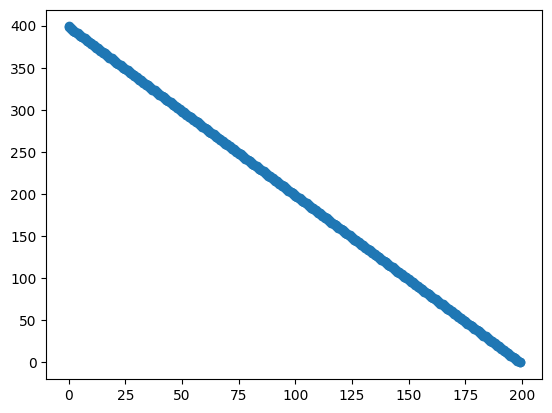

In [77]:
plt.scatter(X, y_reverse)
plt.show()

In [78]:
model = LinearRegression().fit(X, y_reverse)
model.coef_, model.intercept_  # coef_ = [[2.]], intercept_ = [-0.]

(array([[-2.]]), array([398.5]))

In [79]:
result = minimize(log_likelihood, initial_params, args=(X, y_reverse), bounds=bounds)

# 4. Hiển thị kết quả ước lượng
estimated_beta_0, estimated_beta_1, estimated_sigma = result.x

print(f"Tham số ước lượng: beta_0 = {estimated_beta_0:.4f}")
print(f"Tham số ước lượng: beta_1 = {estimated_beta_1:.4f}")

Tham số ước lượng: beta_0 = 398.5000
Tham số ước lượng: beta_1 = -2.0000


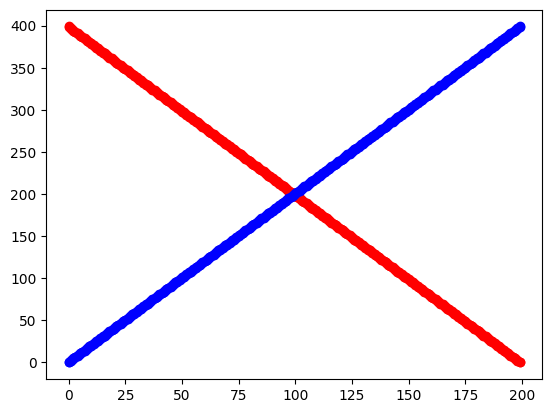

In [81]:
plt.scatter(X, y_reverse, color='red')
plt.scatter(X, y, color='blue')
plt.show()

***Tọa độ trung tâm***

Phương trình giao của 2 đoạn thẳng trong không gian Oxy
$$2 * x + 0.5 = -2 * x + 398.5$$
$$x = 100, y = 200$$


In [ ]:
image_temp = image.copy()
cv2.line(image_temp, (0, 0), (image_attributes['width'], image_attributes['height']), (255, 0, 0), 1) # blue line
cv2.line(image_temp, (0, image_attributes['height']), (image_attributes['width'], 0), (0, 0, 255), 1) # red line
image_temp[199, 99]=[0, 255, 0]
image_temp[200, 100]=[0, 255, 0]
image_temp[200, 99]=[0, 255, 0]  2-

plt.figure(figsize=(6, 12))
plt.imshow(cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB), origin='lower')
